Manifold Learning with Isomap
=============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores the Isomap algorithm for manifold learning.


The <http://waldron.stanford.edu/~isomap/ Isomap> algorithm is introduced in


_A Global Geometric Framework for Nonlinear Dimensionality Reduction,_
J. B. Tenenbaum, V. de Silva and J. C. Langford,
Science 290 (5500): 2319-2323, 22 December 2000.

In [1]:
options(repr.plot.width=6, repr.plot.height=5)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)

source("nt_toolbox/general.R")
source("nt_toolbox/signal.R")

Loading required package: plyr
Loading required package: magrittr

Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image



Graph Approximation of Manifolds
--------------------------------
Manifold learning consist in approximating the parameterization of a
manifold represented as a point cloud.


First we load a simple 3D point cloud, the famous Swiss Roll.


Number of points.

In [2]:
n <- 1000

Random position on the parameteric domain.

In [3]:
x <- array(runif(2*n), c(2,n))

Mapping on the manifold.

In [4]:
v <- 3*pi/2*(.1 + 2*x[1,])
X  <- array(0, c(3,n))
X[2,] <- 20*x[2,]
X[1,] <- - cos(v)*v
X[3,] <- sin(v)*v

Parameter for display.

In [5]:
ms <- 200
el <- 20; az <- -110

Display the point cloud.

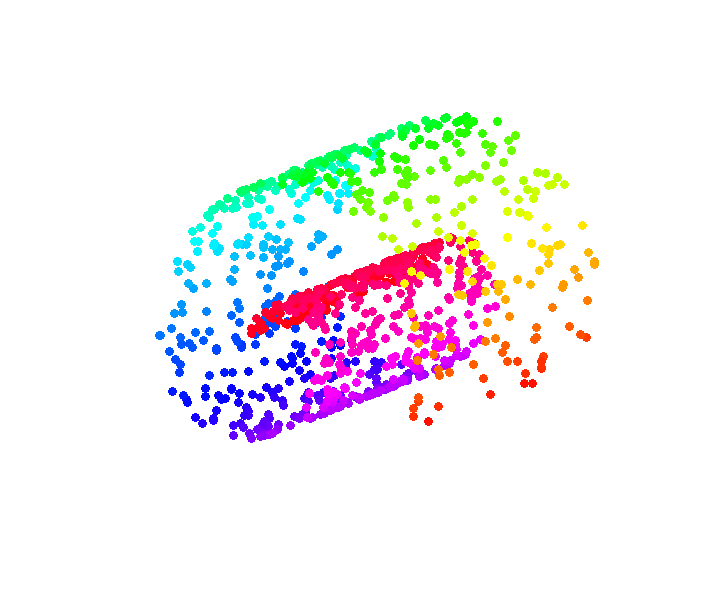

In [6]:
library(scatterplot3d)

color_vec <- rev(rainbow(100))

color_function <- function(x, y, z){
  idx <- round( x**2 + z**2 ) + 1
  return(color_vec[idx])
}

#swiss roll
scatterplot3d(X[1,], X[2,], X[3,], axis=F, grid=F, box=F, type="p", pch=19, color=color_function(X[1,], X[2,], X[3,]))

Compute the pairwise Euclidean distance matrix.

In [7]:
D1 <- array( rep(apply(X**2, 2, sum), n), c(n,n) )
D1 <- sqrt(pmax(D1 + t(D1) - 2*t(X)%*%X, 0))

Number of NN for the graph.

In [8]:
k <- 6

Compute the k-NN connectivity.

In [9]:
DNN <- t( apply( D1, 1, function(l){return(l[order(l)])} ) )
NN <- t( apply( D1, 1, order) )
NN <- NN[,2:(k+1)]
DNN <- DNN[,2:(k+1)]

Adjacency matrix, and weighted adjacency.

In [10]:
B <- t(array(rep(1:n,k), c(n, k)))
I <- as.vector(B) ; J <- as.vector(t(NN))
A <- array(0, c(n,n))
for (idx in 1:(k*n)){ A[I[idx], J[idx]] <- 1}

Weighted adjacency (the metric on the graph).

In [11]:
W <- array(0, c(n,n))
DNN_vector <- as.vector(t(DNN))
for (idx in 1:(k*n)){ W[I[idx], J[idx]] <- DNN_vector[idx]}

Display the graph.

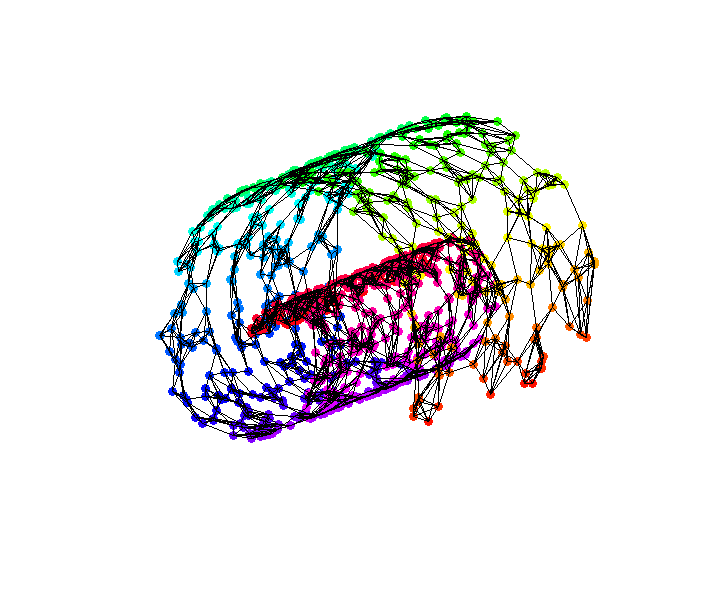

In [12]:
color_vec <- rev(rainbow(100))

color_function <- function(x, y, z){
  idx <- round( x**2 + z**2 ) + 1
  return(color_vec[idx])
}

#swiss roll
s3d <- scatterplot3d(X[1,], X[2,], X[3,], axis=F, grid=F, box=F, type="p", pch=19, color=color_function(X[1,], X[2,], X[3,]))

#graph
xx <- array(0, c(2, k*n)) ; xx[1,] <- X[1,I] ; xx[2,] <- X[1,J]
yy <- array(0, c(2, k*n)) ; yy[1,] <- X[2,I] ; yy[2,] <- X[2,J]
zz <- array(0, c(2, k*n)) ; zz[1,] <- X[3,I] ; zz[2,] <- X[3,J]
    
for (i in 1:length(I)){
    s3d$points3d(xx[,i], yy[,i], zz[,i], type="l", lw=1.5)
}

Floyd Algorithm to Compute Pairwise Geodesic Distances
------------------------------------------------------
A simple algorithm to compute the geodesic distances between all pairs of
points on a graph is Floyd iterative algorithm. Its complexity is
$\mathcal O(n^3)$ where $n$ is the number of points. It is thus quite slow for
sparse graph, where Dijkstra runs in $\mathcal O(n^2\log(n))$.


Floyd algorithm iterates the following update rule, for $k=1,\dots,n$


$D(i,j) \leftarrow \min(D(i,j), D(i,k)+D(k,j))$,


with the initialization $D(i,j)=W(i,j)$ if $W(i,j)>0$, and
$D(i,j)=Inf$ if $W(i,j)=0$.


Make the graph symmetric.

In [13]:
D <- W
D <- (D + t(D))/2.

Initialize the matrix.

In [14]:
D[D == 0] <- Inf

Add connexion between a point and itself.

In [15]:
diag(D) <- Inf
D[is.nan(D)] <- Inf

__Exercise 1__

Implement the Floyd algorithm to compute the full distance matrix
$D$, where $D(i,j)$ is the geodesic distance between

In [16]:
source("nt_solutions/shapes_7_isomap/exo1.R")

In [17]:
## Insert your code here.

Find index of vertices that are not connected to the main manifold.

In [18]:
Iremove <- (D[,1] == Inf)

Remove Inf remaining values (disconnected components).

In [19]:
D[D == Inf] <- 0

Isomap with Classical Multidimensional Scaling
----------------------------------------------
Isomap perform the dimensionality reduction by applying multidimensional
scaling.


Please refers to the tours on Bending Invariant for detail on
Classical MDS (strain minimization).

__Exercise 2__

Perform classical MDS to compute the 2D flattening.

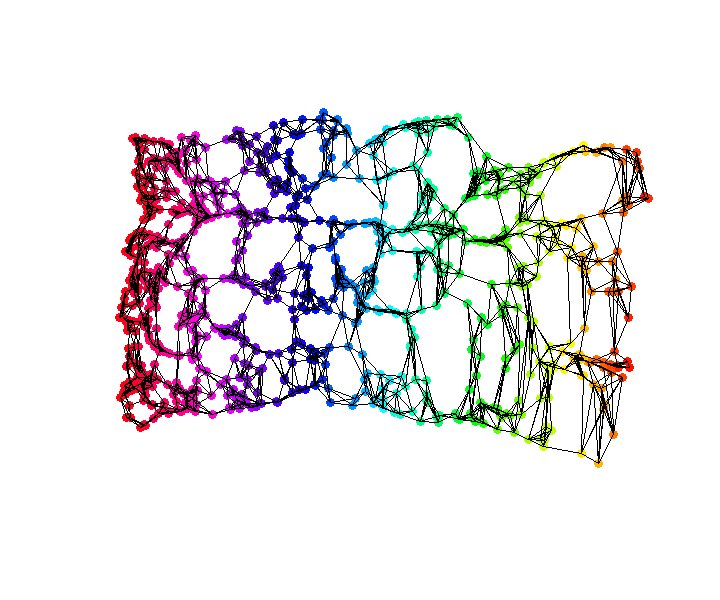

In [20]:
source("nt_solutions/shapes_7_isomap/exo2.R")

In [21]:
## Insert your code here.

Redess the points using the two leading eigenvectors of the covariance matrix (PCA correction).

In [22]:
ev <- eigen( (Xstrain %*% t(Xstrain))/n )
L <- ev$values ; U <- ev$vectors
Xstrain1 <- -t(U) %*% Xstrain

Remove problematic points.

In [23]:
Xstrain1[,Iremove] <- Inf

Display the final result of the dimensionality reduction.

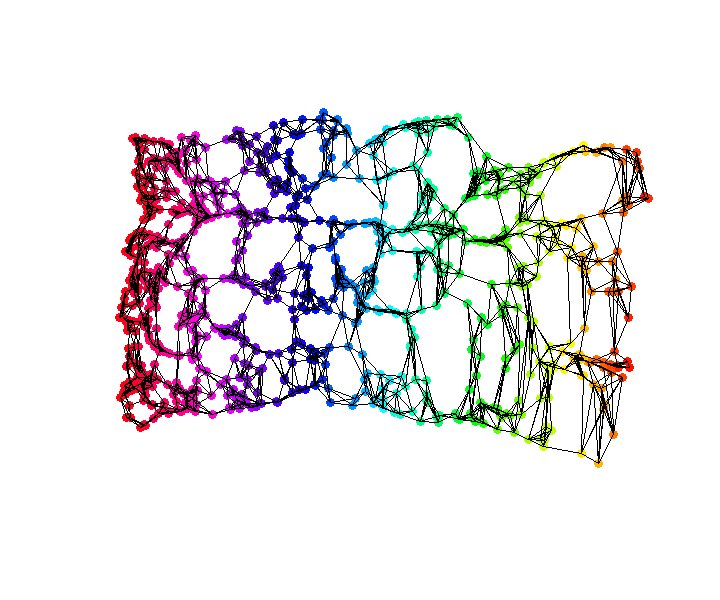

In [24]:
#plot points
plot(Xstrain1[1,], Xstrain1[2,], axes=FALSE, ann=FALSE, pch=19, col=color_function(X[1,], X[2,], X[3,]))

#plot vertices
I <- as.vector(B) ; J <- as.vector(t(NN))
xx <- array(0, c(2, k*n)) ; xx[1,] <- Xstrain1[1,I] ; xx[2,] <- Xstrain1[1,J]
yy <- array(0, c(2, k*n)) ; yy[1,] <- Xstrain1[2,I] ; yy[2,] <- Xstrain1[2,J]

for (i in 1:length(I)){
  lines(xx[,i], yy[,i], col="black", lw=1.5)
}

For comparison, the ideal locations on the parameter domain.

In [25]:
Y <- array(0, c(2,length(v)))
Y[1,] <- v ; Y[2,] <- X[2,]
Y[1,] <- rescale(Y[1,], min(Xstrain[1,]), max(Xstrain[1,]))
Y[2,] <- rescale(Y[2,], min(Xstrain[2,]), max(Xstrain[2,]))

Display the ideal graph on the reduced parameter domain.

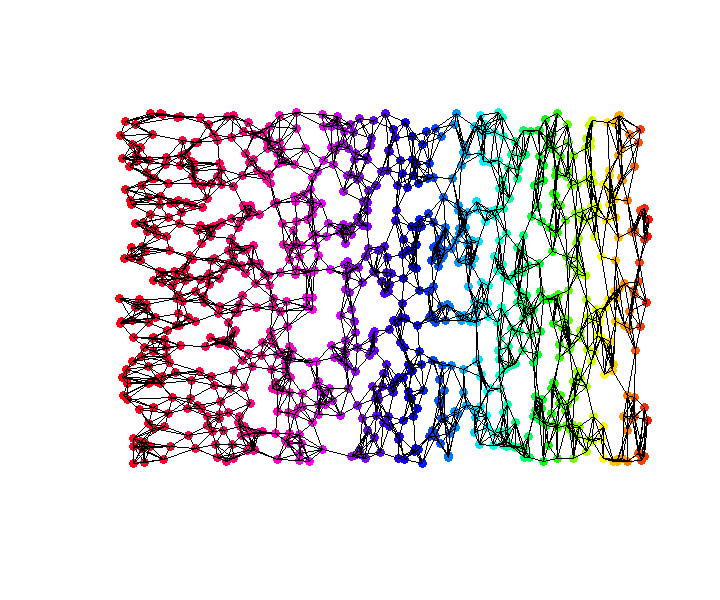

In [26]:
#plot points
plot(Y[1,], Y[2,], axes=FALSE, ann=FALSE, pch=19, col=color_function(X[1,], X[2,], X[3,]))

#plot vertices
I <- as.vector(B) ; J <- as.vector(t(NN))
xx <- array(0, c(2, k*n)) ; xx[1,] <- Y[1,I] ; xx[2,] <- Y[1,J]
yy <- array(0, c(2, k*n)) ; yy[1,] <- Y[2,I] ; yy[2,] <- Y[2,J]

for (i in 1:length(I)){
  lines(xx[,i], yy[,i], col="black", lw=1.5)
}

Isomap with SMACOF Multidimensional Scaling
-------------------------------------------
It is possible to use SMACOF instead of classical scaling.


Please refers to the tours on Bending Invariant for detail on both
Classical MDS (strain minimization) and SMACOF MDS (stress minimization).

__Exercise 3__

Perform stress minimization MDS using SMACOF to compute the 2D flattening.

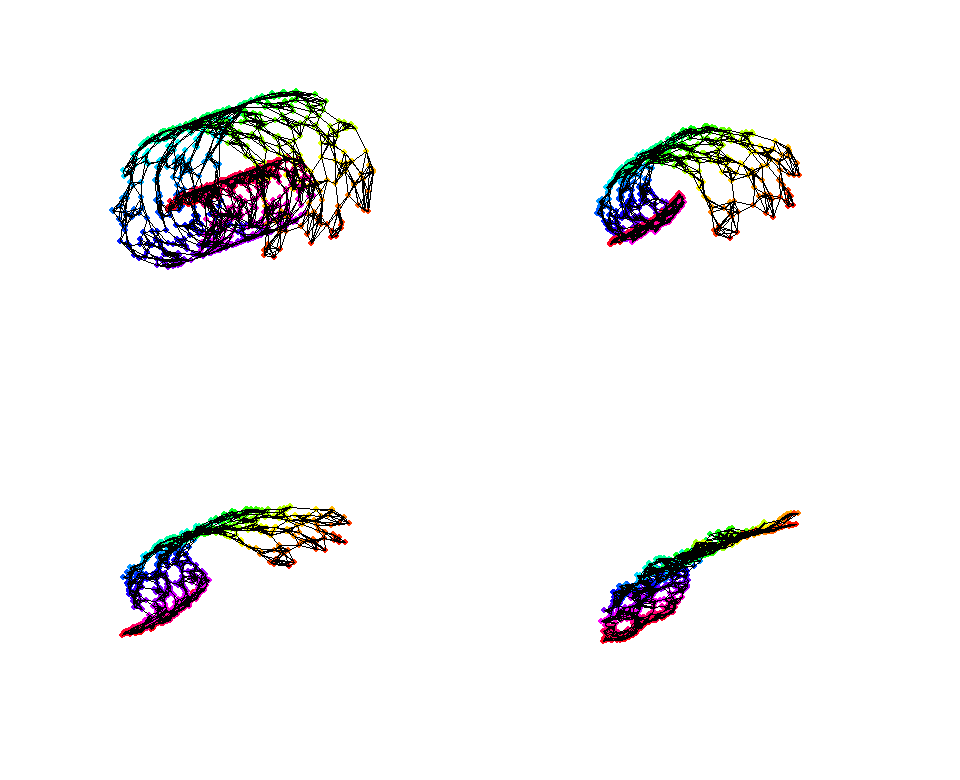

In [27]:
options(repr.plot.width=8, repr.plot.height=6.5)
        
source("nt_solutions/shapes_7_isomap/exo3.R")

In [28]:
## Insert your code here.

Plot stress evolution during minimization.

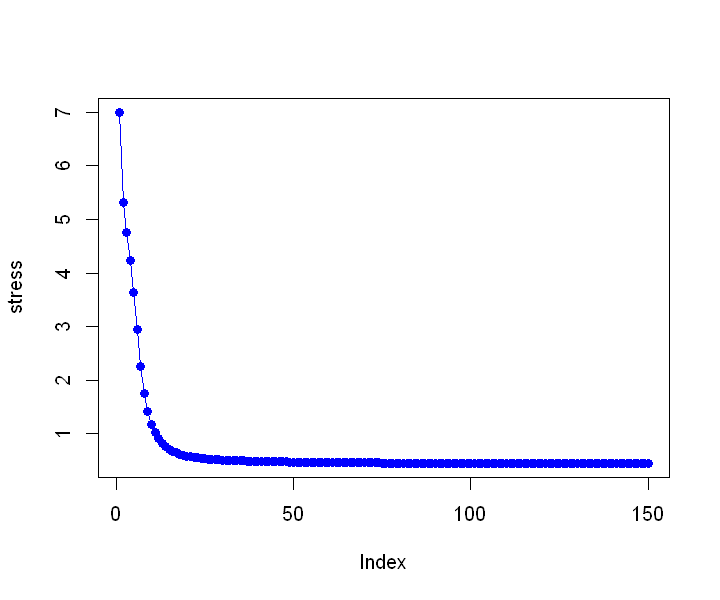

In [29]:
options(repr.plot.width=6, repr.plot.height=5)

plot(stress, type="o", col="blue", pch=19)

Compute the main direction of the point clouds.

In [30]:
ev <- eigen( (Xstress %*% t(Xstress))/n )
L <- ev$values ; U <- ev$vectors

I <- order(L)
L <- L[I]

U <- U[,I[2:3]]

Project the points on the two leading eigenvectors of the covariance matrix (PCA final projection).

In [31]:
Xstress1 <- -t(U) %*% Xstress

Remove problematic points.

In [32]:
Xstress1[,Iremove] <- Inf

Display the final result of the dimensionality reduction.

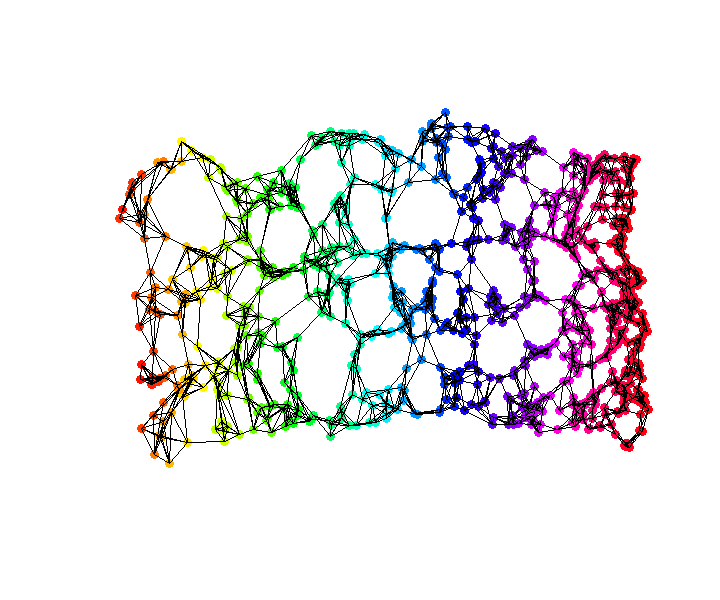

In [33]:
options(repr.plot.width=6, repr.plot.height=5)

#plot points
plot(Xstress1[2,], Xstress1[1,], axes=FALSE, ann=FALSE, pch=19, col=color_function(X[1,], X[2,], X[3,]))

#plot vertices
I <- as.vector(t(array(rep(1:n,k), c(n, k)))) ; J <- as.vector(t(NN))
xx <- array(0, c(2, k*n)) ; xx[1,] <- Xstress1[2,I] ; xx[2,] <- Xstress1[2,J]
yy <- array(0, c(2, k*n)) ; yy[1,] <- Xstress1[1,I] ; yy[2,] <- Xstress1[1,J]

for (i in 1:length(I)){
  lines(xx[,i], yy[,i], col="black", lw=1.5)
}